# Peter and the Wolf: Reinforcement Learning Primer

In this tutorial, we will learn how to apply Reinforcement learning to a problem of path finding. The setting is inspired by [Peter and the Wolf](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) musical fairy tale by Russian composer [Sergei Prokofiev](https://en.wikipedia.org/wiki/Sergei_Prokofiev). It is a story about young pioneer Peter, who bravely goes out of his house to the forest clearing to chase a wolf. We will train machine learning algorithms that will help Peter to explore the surrounding area and build an optimal navigation map.

First, let's import a bunch of useful libraries:

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math


In [5]:
%pip install opencv-python

## Overview of Reinforcement Learning

**Reinforcement Learning** (RL) is a learning technique that allows us to learn an optimal behaviour of an **agent** in some **environment** by running many experiments. An agent in this environment should have some **goal**, defined by a **reward function**.

## The Environment

For simplicity, let's consider Peter's world to be a square board of size `width` x `height`. Each cell in this board can either be:
* **ground**, on which Peter and other creatures can walk
* **water**, on which you obviously cannot walk
* **a tree** or **grass** - a place where you can rest
* **an apple**, which represents something Peter would be glad to find in order to feed himself
* **a wolf**, which is dangerous and should be avoided

To work with the environment, we will define a class called `Board`. In order not to clutter this notebook too much, we have moved all code to work with the board into separate `rlboard` module, which we will now import. You may look inside this module to get more details about the internals of the implementation.

Let's now create a random board and see how it looks:

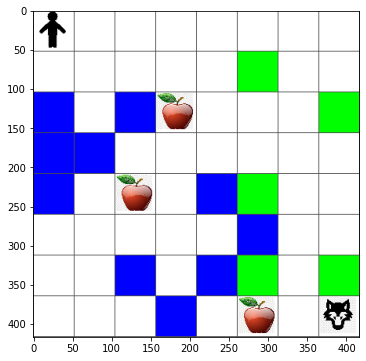

In [6]:
# code block 1
from rlboard import *

width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Actions and Policy

In our example, Peter's goal would be to find an apple, while avoiding the wolf and other obstacles. Define those actions as a dictionary, and map them to pairs of corresponding coordinate changes.

In [7]:
# code block 2
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

The strategy of our agent (Peter) is defined by a so-called **policy**. Let's consider the simplest policy called **random walk**.

## Random walk

Let's first solve our problem by implementing a random walk strategy.

In [8]:
# Let's run a random walk experiment several times and see the average number of steps taken: code block 3
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

In [9]:
# code block 4
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Reward Function

To make our policy more intelligent, we need to understand which moves are "better" than others.



In [10]:
#code block 5
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Learning

Build a Q-Table, or multi-dimensional array. Since our board has dimensions `width` x `height`, we can represent Q-Table by a numpy array with shape `width` x `height` x `len(actions)`:

In [11]:
# code block 6
Q = np.ones((width,height,len(actions)),dtype=np.float64)*1.0/len(actions)

Pass the Q-Table to the `plot` function in order to visualize the table on the board:

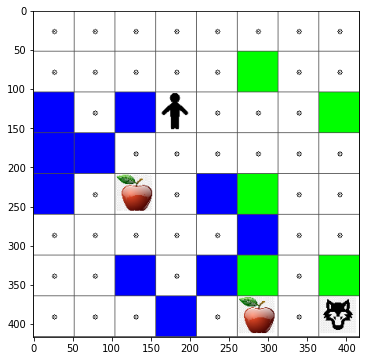

In [12]:
m.plot(Q)


## Essence of Q-Learning: Bellman Equation and  Learning Algorithm

Write a pseudo-code for our leaning algorithm:

* Initialize Q-Table Q with equal numbers for all states and actions
* Set learning rate $\alpha\leftarrow 1$
* Repeat simulation many times
   1. Start at random position
   1. Repeat
        1. Select an action $a$ at state $s$
        2. Exectute action by moving to a new state $s'$
        3. If we encounter end-of-game condition, or total reward is too small - exit simulation  
        4. Compute reward $r$ at the new state
        5. Update Q-Function according to Bellman equation: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Update total reward and decrease $\alpha$.

## Exploit vs. Explore

The best approach is to balance between exploration and exploitation. As we learn more about our environment, we would be more likely to follow the optimal route, however, choosing the unexplored path once in a while.

## Python Implementation

Now we are ready to implement the learning algorithm. Before that, we also need some function that will convert arbitrary numbers in the Q-Table into a vector of probabilities for corresponding actions:

In [13]:
# code block 7
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

We add a small amount of `eps` to the original vector in order to avoid division by 0 in the initial case, when all components of the vector are identical.

The actual learning algorithm we will run for 5000 experiments, also called **epochs**: 

In [14]:

from IPython.display import clear_output

lpath = []

# code block 8
for epoch in range(5000):

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            lpath.append(n)
            break
        alpha = np.exp(-n / 10e5)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

After executing this algorithm, the Q-Table should be updated with values that define the attractiveness of different actions at each step. Visualize the table here:

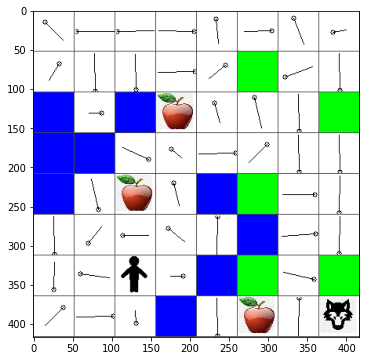

In [15]:
m.plot(Q)

## Checking the Policy

Since Q-Table lists the "attractiveness" of each action at each state, it is quite easy to use it to define the efficient navigation in our world. In the simplest case, we can just select the action corresponding to the highest Q-Table value:

In [16]:
# code block 9
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

If you try the code above several times, you may notice that sometimes it just "hangs", and you need to press the STOP button in the notebook to interrupt it. 

> **Task 1:** Modify the `walk` function to limit the maximum length of path by a certain number of steps (say, 100), and watch the code above return this value from time to time.

> **Task 2:** Modify the `walk` function so that it does not go back to the places where is has already been previously. This will prevent `walk` from looping, however, the agent can still end up being "trapped" in a location from which it is unable to escape.

In [17]:

# code block 10
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 5.11, eaten by wolf: 0 times


## Investigating the Learning Process

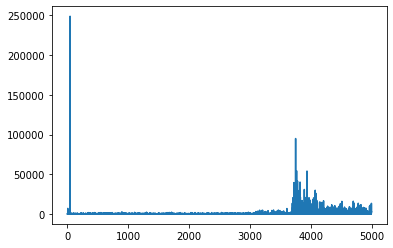

In [18]:
plt.plot(lpath)

## Exercise
## A more realistic Peter and the Wolf world


